In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm
from sklearn import metrics
from random import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


N
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Lowest Error In Validation _MSE_  152.71541441868632
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
691/691 [==============================] - 1s 2ms/step
A
Lowest Error In Validation _MSE_  157.94287875969545
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
749/749 [==============================] - 3s 4ms/step
O
Lowest Error In Validation _MSE_  153.04034515933148
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
760/760 [==============================] - 5s 6ms/step
K
Lowest Error In Validation _MSE_  146.37830233162796
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
758/758 [==============================] - 7s 9ms/step
E

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117209). Check your callbacks.
  % delta_t_median)


Lowest Error In Validation _MSE_  163.92301384797707
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
761/761 [==============================] - 37s 48ms/step


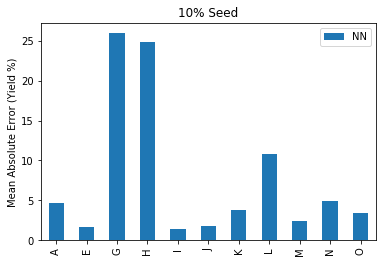

In [5]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
pd.options.mode.chained_assignment = None


XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P']
X = data[XLabels]
#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)
data[XLabels] = X

papers = data['ID'].unique()
shuffle(papers)

#Remvoing papers from test list if they have less  than 10 points
papersWithLessThanXPoints = []
for paper in papers:
    dataFromPaper = data[data['ID'] == paper]
    if len(dataFromPaper.index) < 10:
        papersWithLessThanXPoints.append(paper)
papers = [x for x in papers if x not in papersWithLessThanXPoints]

numPapers = len(papers)
papersPerGroup = 2
numBins = 10

error_Frame = pd.DataFrame(columns=['ID', 'NN'])
          
numEpoch = 3000

#10% Seed

for paper in papers:
    print(paper)
    train_Frame = data[data['ID'] != paper]
    test_Frame = data[data['ID'] == paper]
    

    ##Seeding with 10
    
    test_Frame = test_Frame.sample(frac=1).reset_index(drop=True)
    
    lenTest = len(test_Frame.index)
    
    
    train_Frame.append(test_Frame.iloc[:int(lenTest * 0.1), :])
    test_Frame = train_Frame.iloc[int(lenTest * 0.1):, :]

    
    
    papers = train_Frame['ID'].unique()
    
    
    numPapers = len(papers)
    #combos = [papers[x:x + papersPerGroup] for x in range(0, len(papers), papersPerGroup)]  
    combos = []
    for x in range(0, len(papers), papersPerGroup):
        if x + papersPerGroup < len(papers):
            combos.append(papers[x:x + papersPerGroup])
        else:
            combos.append(papers[x:])

    lenTrain = len(train_Frame.index)
    train_Frame, valid_Frame, train_valid_Frame = train_Frame.iloc[:int(lenTrain * 0.8), :], train_Frame.iloc[int(lenTrain * 0.8):, :], train_Frame

    #Calculating Sample Weight
    bins = train_Frame['Yield'].value_counts(bins=numBins)
    for i in train_Frame.index:
        for j in bins.index:
            if int(train_Frame.at[i, 'Yield']) in j:
                train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

            
    bins = train_valid_Frame['Yield'].value_counts(bins=numBins)
    for i in train_valid_Frame.index:
        for j in bins.index:
            if int(train_valid_Frame.at[i, 'Yield']) in j:
                train_valid_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()
    
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

    train_weights = train_Frame['Sample_Weight']
    train_valid_weights = train_valid_Frame['Sample_Weight']
    

    ##NN
    learningRates = [0.002, 0.005, 0.01, 0.02]
    batchSizes = [128]
    dropoutRates = [0.00, 0.1]
    errors = []
    for lr_ in learningRates:
        for bs in batchSizes:
            for dr in dropoutRates:
                sumErrors = 0
                for c in combos:
                    train_Frame = train_valid_Frame[~train_valid_Frame['ID'].isin(c)]
                    valid_Frame = train_valid_Frame[train_valid_Frame['ID'].isin(c)]

                    ##Calculating Sample Weight again just for train frame, because it's different
                    bins = train_Frame['Yield'].value_counts(bins=numBins)
                    for i in train_Frame.index:
                        for j in bins.index:
                            if int(train_Frame.at[i, 'Yield']) in j:
                                train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

                    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
                    X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

                    train_weights = train_Frame['Sample_Weight']
                    
                    model = Sequential()
                    model.add(Dense(units=12, activation='sigmoid', input_dim=13))
                    model.add(Dropout(dr))
                    model.add(Dense(units=12, activation='sigmoid'))
                    model.add(Dense(units=6, activation='sigmoid'))
                    model.add(Dense(units=6, activation='sigmoid'))
                    model.add(Dense(units=1, activation='softplus'))

                    sgd = SGD(lr=lr_)  
                    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

                
                    model.fit(X_train, y_train, sample_weight=np.asarray(train_weights), epochs=numEpoch, batch_size=bs ,verbose=0)

#                     loss_and_metrics = model.evaluate(X_valid, y_valid,batch_size=bs)
                    
#                     print(X_valid)
                    y_pred = model.predict(X_valid, batch_size=bs)
                    y_pred = y_pred.flatten()
                    error =  metrics.mean_absolute_error(y_valid, y_pred)
                    sumErrors = sumErrors + error
                errors.append(sumErrors)
    index_of_lowest_error = np.argmin(errors)
          
    print("Lowest Error In Validation _MSE_ ", np.min(errors))

    best_lr = learningRates[int(index_of_lowest_error / (len(batchSizes) * len(dropoutRates)))] #Good
    best_bs = batchSizes[int((index_of_lowest_error % (len(batchSizes) * len(dropoutRates)))/len(dropoutRates))] #Good
    best_dr = dropoutRates[int(index_of_lowest_error % len(dropoutRates))] #Good 
    print("Best Learning Rate is: ",best_lr)
    print("Best Batch Size is: ", best_bs)
    print("Best Dropout Rate is: ", best_dr)    


    #Using best values

    model = Sequential()
    model.add(Dense(units=12, activation='sigmoid', input_dim=13))
    model.add(Dropout(best_dr))
    model.add(Dense(units=12, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=1, activation='softplus'))

    sgd = SGD(lr=best_lr)  
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

    model.fit(X_train_valid, y_train_valid, sample_weight=np.asarray(train_valid_weights), epochs=numEpoch, batch_size=best_bs ,verbose=0)

    loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

    y_pred = model.predict(X_test, batch_size=best_bs)
    y_pred = y_pred.flatten()
          
    mseNN = metrics.mean_absolute_error(y_test, y_pred)
  

    row = [[paper, mseNN]]
    tempDf = pd.DataFrame(row, columns=['ID', 'NN'])
    error_Frame = pd.concat([error_Frame, tempDf], ignore_index=True)
    error_Frame.index = error_Frame['ID'].values
    error_Frame = error_Frame.sort_index()
    error_Frame.to_csv("10SeedCrossValidNN.csv")


    
error_Frame.reset_index()
error_Frame.index = error_Frame['ID'].values
error_Frame = error_Frame.sort_index()


error_Frame.plot(kind='bar', stacked=False)
error_Frame.to_csv("10SeedCrossValidNN.csv")

plt.ylabel('Mean Absolute Error (Yield %)')
plt.title("10% Seed")
plt.savefig("10Seed", dpi=600, bbox_inches='tight')



O
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
758/758 [==============================] - 1s 1ms/step
K
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
756/756 [==============================] - 1s 1ms/step
M
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
706/706 [==============================] - 1s 2ms/step
A
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
746/746 [==============================] - 1s 1ms/step
I
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
759/759 [==============================] - 1s 2ms/step
J
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
704/704 [==============================] - 1s 2ms/step
N
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
682/682 [==============================] - 1s 2ms/step
E
Best Learning Rate is:  0.02
Bes

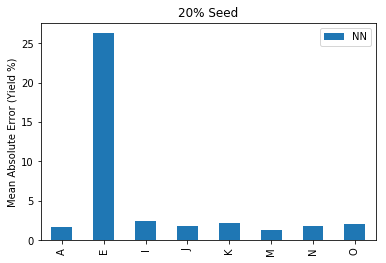

In [8]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
pd.options.mode.chained_assignment = None


XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P']
X = data[XLabels]
#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)
data[XLabels] = X

papers = data['ID'].unique()
shuffle(papers)

#Remvoing papers from test list if they have less  than 10 points
papersWithLessThanXPoints = []
for paper in papers:
    dataFromPaper = data[data['ID'] == paper]
    if len(dataFromPaper.index) < 20:
        papersWithLessThanXPoints.append(paper)
papers = [x for x in papers if x not in papersWithLessThanXPoints]

numPapers = len(papers)
papersPerGroup = 2
numBins = 10

error_Frame = pd.DataFrame(columns=['ID', 'NN'])
          
numEpoch = 3000

#10% Seed

for paper in papers:
    print(paper)
    train_Frame = data[data['ID'] != paper]
    test_Frame = data[data['ID'] == paper]
    

    ##Seeding with 20
    
    test_Frame = test_Frame.sample(frac=1).reset_index(drop=True)
    
    lenTest = len(test_Frame.index)
    
    
    train_Frame.append(test_Frame.iloc[:int(lenTest * 0.2), :])
    test_Frame = train_Frame.iloc[int(lenTest * 0.2):, :]

    
    
    papers = train_Frame['ID'].unique()
    
    
    numPapers = len(papers)
    #combos = [papers[x:x + papersPerGroup] for x in range(0, len(papers), papersPerGroup)]  
    combos = []
    for x in range(0, len(papers), papersPerGroup):
        if x + papersPerGroup < len(papers):
            combos.append(papers[x:x + papersPerGroup])
        else:
            combos.append(papers[x:])

    lenTrain = len(train_Frame.index)
    train_Frame, valid_Frame, train_valid_Frame = train_Frame.iloc[:int(lenTrain * 0.8), :], train_Frame.iloc[int(lenTrain * 0.8):, :], train_Frame

    #Calculating Sample Weight
    bins = train_Frame['Yield'].value_counts(bins=numBins)
    for i in train_Frame.index:
        for j in bins.index:
            if int(train_Frame.at[i, 'Yield']) in j:
                train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

            
    bins = train_valid_Frame['Yield'].value_counts(bins=numBins)
    for i in train_valid_Frame.index:
        for j in bins.index:
            if int(train_valid_Frame.at[i, 'Yield']) in j:
                train_valid_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()
    
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

    train_weights = train_Frame['Sample_Weight']
    train_valid_weights = train_valid_Frame['Sample_Weight']
    


    best_lr = 0.02
    best_bs = 128
    best_dr = 0.0
    print("Best Learning Rate is: ",best_lr)
    print("Best Batch Size is: ", best_bs)
    print("Best Dropout Rate is: ", best_dr)    


    #Using best values

    model = Sequential()
    model.add(Dense(units=12, activation='sigmoid', input_dim=13))
    model.add(Dropout(best_dr))
    model.add(Dense(units=12, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=1, activation='softplus'))

    sgd = SGD(lr=best_lr)  
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

    model.fit(X_train_valid, y_train_valid, sample_weight=np.asarray(train_valid_weights), epochs=numEpoch, batch_size=best_bs ,verbose=0)

    loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

    y_pred = model.predict(X_test, batch_size=best_bs)
    y_pred = y_pred.flatten()
          
    mseNN = metrics.mean_absolute_error(y_test, y_pred)
  

    row = [[paper, mseNN]]
    tempDf = pd.DataFrame(row, columns=['ID', 'NN'])
    error_Frame = pd.concat([error_Frame, tempDf], ignore_index=True)
    error_Frame.index = error_Frame['ID'].values
    error_Frame = error_Frame.sort_index()
    error_Frame.to_csv("20SeedCrossValidNN.csv")


    
error_Frame.reset_index()
error_Frame.index = error_Frame['ID'].values
error_Frame = error_Frame.sort_index()


error_Frame.plot(kind='bar', stacked=False)
error_Frame.to_csv("20SeedCrossValidNN0.csv")

plt.ylabel('Mean Absolute Error (Yield %)')
plt.title("20% Seed")
plt.savefig("20SeedCrossValidNN0", dpi=600, bbox_inches='tight')




I
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
753/753 [==============================] - 1s 2ms/step
N
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
657/657 [==============================] - 1s 2ms/step
O
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
751/751 [==============================] - 1s 2ms/step
E
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
184/184 [==============================] - 1s 7ms/step
A
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
736/736 [==============================] - 1s 2ms/step
K
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
748/748 [==============================] - 1s 2ms/step
M
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
687/687 [==============================] - 1s 2ms/step
J
Best Learning Rate is:  0.02
Bes

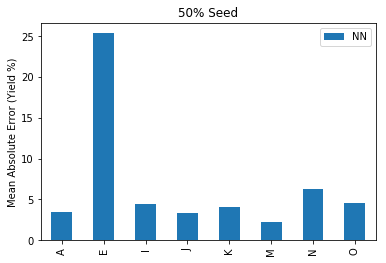

In [9]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
pd.options.mode.chained_assignment = None


XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P']
X = data[XLabels]
#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)
data[XLabels] = X

papers = data['ID'].unique()
shuffle(papers)

#Remvoing papers from test list if they have less  than 10 points
papersWithLessThanXPoints = []
for paper in papers:
    dataFromPaper = data[data['ID'] == paper]
    if len(dataFromPaper.index) < 20:
        papersWithLessThanXPoints.append(paper)
papers = [x for x in papers if x not in papersWithLessThanXPoints]

numPapers = len(papers)
papersPerGroup = 2
numBins = 10

error_Frame = pd.DataFrame(columns=['ID', 'NN'])
          
numEpoch = 3000

#10% Seed

for paper in papers:
    print(paper)
    train_Frame = data[data['ID'] != paper]
    test_Frame = data[data['ID'] == paper]
    

    ##Seeding with 20
    
    test_Frame = test_Frame.sample(frac=1).reset_index(drop=True)
    
    lenTest = len(test_Frame.index)
    
    
    train_Frame.append(test_Frame.iloc[:int(lenTest * 0.5), :])
    test_Frame = train_Frame.iloc[int(lenTest * 0.5):, :]

    
    
    papers = train_Frame['ID'].unique()
    
    
    numPapers = len(papers)
    #combos = [papers[x:x + papersPerGroup] for x in range(0, len(papers), papersPerGroup)]  
    combos = []
    for x in range(0, len(papers), papersPerGroup):
        if x + papersPerGroup < len(papers):
            combos.append(papers[x:x + papersPerGroup])
        else:
            combos.append(papers[x:])

    lenTrain = len(train_Frame.index)
    train_Frame, valid_Frame, train_valid_Frame = train_Frame.iloc[:int(lenTrain * 0.8), :], train_Frame.iloc[int(lenTrain * 0.8):, :], train_Frame

    #Calculating Sample Weight
    bins = train_Frame['Yield'].value_counts(bins=numBins)
    for i in train_Frame.index:
        for j in bins.index:
            if int(train_Frame.at[i, 'Yield']) in j:
                train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

            
    bins = train_valid_Frame['Yield'].value_counts(bins=numBins)
    for i in train_valid_Frame.index:
        for j in bins.index:
            if int(train_valid_Frame.at[i, 'Yield']) in j:
                train_valid_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()
    
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

    train_weights = train_Frame['Sample_Weight']
    train_valid_weights = train_valid_Frame['Sample_Weight']
    


    best_lr = 0.02
    best_bs = 128
    best_dr = 0.1
    print("Best Learning Rate is: ",best_lr)
    print("Best Batch Size is: ", best_bs)
    print("Best Dropout Rate is: ", best_dr)    


    #Using best values

    model = Sequential()
    model.add(Dense(units=12, activation='sigmoid', input_dim=13))
    model.add(Dropout(best_dr))
    model.add(Dense(units=12, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=1, activation='softplus'))

    sgd = SGD(lr=best_lr)  
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

    model.fit(X_train_valid, y_train_valid, sample_weight=np.asarray(train_valid_weights), epochs=numEpoch, batch_size=best_bs ,verbose=0)

    loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

    y_pred = model.predict(X_test, batch_size=best_bs)
    y_pred = y_pred.flatten()
          
    mseNN = metrics.mean_absolute_error(y_test, y_pred)
  

    row = [[paper, mseNN]]
    tempDf = pd.DataFrame(row, columns=['ID', 'NN'])
    error_Frame = pd.concat([error_Frame, tempDf], ignore_index=True)
    error_Frame.index = error_Frame['ID'].values
    error_Frame = error_Frame.sort_index()
    error_Frame.to_csv("50SeedCrossValidNN.csv")


    
error_Frame.reset_index()
error_Frame.index = error_Frame['ID'].values
error_Frame = error_Frame.sort_index()


error_Frame.plot(kind='bar', stacked=False)
error_Frame.to_csv("50SeedCrossValidNN.csv")

plt.ylabel('Mean Absolute Error (Yield %)')
plt.title("50% Seed")
plt.savefig("50SeedCrossValidNN", dpi=600, bbox_inches='tight')




J
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
717/717 [==============================] - 2s 3ms/step
E
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
384/384 [==============================] - 2s 5ms/step
I
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
763/763 [==============================] - 2s 3ms/step
O
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
762/762 [==============================] - 2s 3ms/step
N
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
699/699 [==============================] - 2s 3ms/step
K
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
760/760 [==============================] - 2s 3ms/step
M
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
719/719 [==============================] - 2s 3ms/step
A
Best Learning Rate is:  0.02
Bes

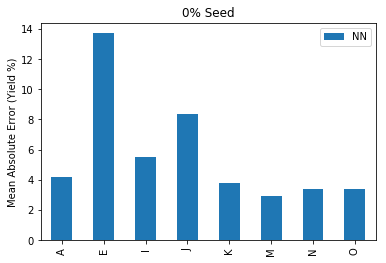

In [14]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
pd.options.mode.chained_assignment = None


XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P']
X = data[XLabels]
#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)
data[XLabels] = X

papers = data['ID'].unique()
shuffle(papers)

#Remvoing papers from test list if they have less  than 10 points
papersWithLessThanXPoints = []
for paper in papers:
    dataFromPaper = data[data['ID'] == paper]
    if len(dataFromPaper.index) < 20:
        papersWithLessThanXPoints.append(paper)
papers = [x for x in papers if x not in papersWithLessThanXPoints]

numPapers = len(papers)
papersPerGroup = 2
numBins = 10

error_Frame = pd.DataFrame(columns=['ID', 'NN'])
          
numEpoch = 3000

#10% Seed

for paper in papers:
    print(paper)
    train_Frame = data[data['ID'] != paper]
    test_Frame = data[data['ID'] == paper]
    

    ##Seeding with 20
    
    test_Frame = test_Frame.sample(frac=1).reset_index(drop=True)
    
    lenTest = len(test_Frame.index)
    
    
    train_Frame.append(test_Frame.iloc[:int(lenTest * 0.0), :])
    test_Frame = train_Frame.iloc[int(lenTest * 0.0):, :]

    
    
    papers = train_Frame['ID'].unique()
    
    
    numPapers = len(papers)
    #combos = [papers[x:x + papersPerGroup] for x in range(0, len(papers), papersPerGroup)]  
    combos = []
    for x in range(0, len(papers), papersPerGroup):
        if x + papersPerGroup < len(papers):
            combos.append(papers[x:x + papersPerGroup])
        else:
            combos.append(papers[x:])

    lenTrain = len(train_Frame.index)
    train_Frame, valid_Frame, train_valid_Frame = train_Frame.iloc[:int(lenTrain * 0.8), :], train_Frame.iloc[int(lenTrain * 0.8):, :], train_Frame

    #Calculating Sample Weight
    bins = train_Frame['Yield'].value_counts(bins=numBins)
    for i in train_Frame.index:
        for j in bins.index:
            if int(train_Frame.at[i, 'Yield']) in j:
                train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

            
    bins = train_valid_Frame['Yield'].value_counts(bins=numBins)
    for i in train_valid_Frame.index:
        for j in bins.index:
            if int(train_valid_Frame.at[i, 'Yield']) in j:
                train_valid_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()
    
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

    train_weights = train_Frame['Sample_Weight']
    train_valid_weights = train_valid_Frame['Sample_Weight']
    


    best_lr = 0.02
    best_bs = 128
    best_dr = 0.1
    print("Best Learning Rate is: ",best_lr)
    print("Best Batch Size is: ", best_bs)
    print("Best Dropout Rate is: ", best_dr)    


    #Using best values

    model = Sequential()
    model.add(Dense(units=12, activation='sigmoid', input_dim=13))
    model.add(Dropout(best_dr))
    model.add(Dense(units=12, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=1, activation='softplus'))

    sgd = SGD(lr=best_lr)  
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

    model.fit(X_train_valid, y_train_valid, sample_weight=np.asarray(train_valid_weights), epochs=numEpoch, batch_size=best_bs ,verbose=0)

    loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

    y_pred = model.predict(X_test, batch_size=best_bs)
    y_pred = y_pred.flatten()
          
    mseNN = metrics.mean_absolute_error(y_test, y_pred)
  

    row = [[paper, mseNN]]
    tempDf = pd.DataFrame(row, columns=['ID', 'NN'])
    error_Frame = pd.concat([error_Frame, tempDf], ignore_index=True)
    error_Frame.index = error_Frame['ID'].values
    error_Frame = error_Frame.sort_index()
    error_Frame.to_csv("0SeedCrossValidNN.csv")


    
error_Frame.reset_index()
error_Frame.index = error_Frame['ID'].values
error_Frame = error_Frame.sort_index()


error_Frame.plot(kind='bar', stacked=False)
error_Frame.to_csv("0SeedCrossValidNN.csv")

plt.ylabel('Mean Absolute Error (Yield %)')
plt.title("0% Seed")
plt.savefig("0SeedCrossValidNN", dpi=600, bbox_inches='tight')




A
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
749/749 [==============================] - 2s 3ms/step
E
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
344/344 [==============================] - 2s 6ms/step
M
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
713/713 [==============================] - 2s 3ms/step
J
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
711/711 [==============================] - 2s 3ms/step
O
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
760/760 [==============================] - 2s 3ms/step
K
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
758/758 [==============================] - 2s 3ms/step
I
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
761/761 [==============================] - 2s 3ms/step
N
Best Learning Rate is:  0.02
Bes

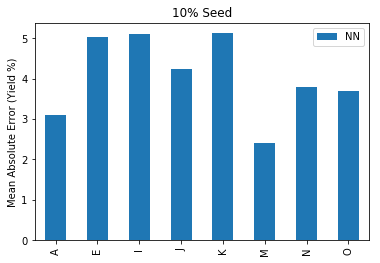

In [13]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
pd.options.mode.chained_assignment = None


XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P']
X = data[XLabels]
#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)
data[XLabels] = X

papers = data['ID'].unique()
shuffle(papers)

#Remvoing papers from test list if they have less  than 10 points
papersWithLessThanXPoints = []
for paper in papers:
    dataFromPaper = data[data['ID'] == paper]
    if len(dataFromPaper.index) < 20:
        papersWithLessThanXPoints.append(paper)
papers = [x for x in papers if x not in papersWithLessThanXPoints]

numPapers = len(papers)
papersPerGroup = 2
numBins = 10

error_Frame = pd.DataFrame(columns=['ID', 'NN'])
          
numEpoch = 3000

#10% Seed

for paper in papers:
    print(paper)
    train_Frame = data[data['ID'] != paper]
    test_Frame = data[data['ID'] == paper]
    

    ##Seeding with 20
    
    test_Frame = test_Frame.sample(frac=1).reset_index(drop=True)
    
    lenTest = len(test_Frame.index)
    
    
    train_Frame.append(test_Frame.iloc[:int(lenTest * 0.10), :])
    test_Frame = train_Frame.iloc[int(lenTest * 0.10):, :]

    
    
    papers = train_Frame['ID'].unique()
    
    
    numPapers = len(papers)
    #combos = [papers[x:x + papersPerGroup] for x in range(0, len(papers), papersPerGroup)]  
    combos = []
    for x in range(0, len(papers), papersPerGroup):
        if x + papersPerGroup < len(papers):
            combos.append(papers[x:x + papersPerGroup])
        else:
            combos.append(papers[x:])

    lenTrain = len(train_Frame.index)
    train_Frame, valid_Frame, train_valid_Frame = train_Frame.iloc[:int(lenTrain * 0.8), :], train_Frame.iloc[int(lenTrain * 0.8):, :], train_Frame

    #Calculating Sample Weight
    bins = train_Frame['Yield'].value_counts(bins=numBins)
    for i in train_Frame.index:
        for j in bins.index:
            if int(train_Frame.at[i, 'Yield']) in j:
                train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

            
    bins = train_valid_Frame['Yield'].value_counts(bins=numBins)
    for i in train_valid_Frame.index:
        for j in bins.index:
            if int(train_valid_Frame.at[i, 'Yield']) in j:
                train_valid_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()
    
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

    train_weights = train_Frame['Sample_Weight']
    train_valid_weights = train_valid_Frame['Sample_Weight']
    


    best_lr = 0.02
    best_bs = 128
    best_dr = 0.1
    print("Best Learning Rate is: ",best_lr)
    print("Best Batch Size is: ", best_bs)
    print("Best Dropout Rate is: ", best_dr)    


    #Using best values

    model = Sequential()
    model.add(Dense(units=12, activation='sigmoid', input_dim=13))
    model.add(Dropout(best_dr))
    model.add(Dense(units=12, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=1, activation='softplus'))

    sgd = SGD(lr=best_lr)  
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

    model.fit(X_train_valid, y_train_valid, sample_weight=np.asarray(train_valid_weights), epochs=numEpoch, batch_size=best_bs ,verbose=0)

    loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

    y_pred = model.predict(X_test, batch_size=best_bs)
    y_pred = y_pred.flatten()
          
    mseNN = metrics.mean_absolute_error(y_test, y_pred)
  

    row = [[paper, mseNN]]
    tempDf = pd.DataFrame(row, columns=['ID', 'NN'])
    error_Frame = pd.concat([error_Frame, tempDf], ignore_index=True)
    error_Frame.index = error_Frame['ID'].values
    error_Frame = error_Frame.sort_index()
    error_Frame.to_csv("10SeedCrossValidNN.csv")


    
error_Frame.reset_index()
error_Frame.index = error_Frame['ID'].values
error_Frame = error_Frame.sort_index()


error_Frame.plot(kind='bar', stacked=False)
error_Frame.to_csv("10SeedCrossValidNN.csv")

plt.ylabel('Mean Absolute Error (Yield %)')
plt.title("10% Seed")
plt.savefig("10SeedCrossValidNN", dpi=600, bbox_inches='tight')


